## download data

In [1]:
!pip install torch==1.12
!pip install torchvision==0.13
!pip install nltk==3.7
!pip install pycocotools==2.0.4

import torch
import torchvision
import nltk
import pycocotools

print(torch.__version__)
print(torchvision.__version__)
print(nltk.__version__)

1.12.0
0.13.0
3.7


In [2]:
# linux
!apt-get install wget
# mac
!brew install wget
 
# create a data directory
!mkdir data_dir
 
# download images and annotations to the data directory
!wget http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip -P ./data_dir/
!wget http://images.cocodataset.org/zips/train2014.zip -P ./data_dir/
!wget http://images.cocodataset.org/zips/val2014.zip -P ./data_dir/
    
# extract zipped images and annotations and remove the zip files
!unzip ./data_dir/captions_train-val2014.zip -d ./data_dir/
!rm ./data_dir/captions_train-val2014.zip
!unzip ./data_dir/train2014.zip -d ./data_dir/
!rm ./data_dir/train2014.zip 
!unzip ./data_dir/val2014.zip -d ./data_dir/ 
!rm ./data_dir/val2014.zip

zsh:1: command not found: apt-get
Running `brew update --auto-update`...
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Casks
bluebubbles                              lectrote

You have 6 outdated formulae installed.
You can upgrade them with brew upgrade
or list them with brew outdated.

To reinstall 1.21.3, run:
  brew reinstall wget
mkdir: data_dir: File exists
--2022-09-04 19:42:22--  http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip
Resolving msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)... 20.60.195.163
Connecting to msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)|20.60.195.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19673183 (19M) [application/octet-stream Charset=UTF-8]
Saving to: ‘./data_dir/captions_train-val2014.zip’

captions_train-val2 100%[===================>]  18.76M   672KB/s    in 21s     

2022-09-04 19:42:43 (928 KB/s) - ‘./data_dir/ca

## import dependencies

In [3]:
import os
import nltk
import pickle
import numpy as np
from PIL import Image
from collections import Counter
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
 
import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ashish.jha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## build vocab

In [5]:
class Vocab(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.w2i = {}
        self.i2w = {}
        self.index = 0
 
    def __call__(self, token):
        if not token in self.w2i:
            return self.w2i['<unk>']
        return self.w2i[token]
 
    def __len__(self):
        return len(self.w2i)
    def add_token(self, token):
        if not token in self.w2i:
            self.w2i[token] = self.index
            self.i2w[self.index] = token
            self.index += 1

def build_vocabulary(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)
 
        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))
 
    # If the word frequency is less than 'threshold', then the word is discarded.
    tokens = [token for token, cnt in counter.items() if cnt >= threshold]
 
    # Create a vocab wrapper and add some special tokens.
    vocab = Vocab()
    vocab.add_token('<pad>')
    vocab.add_token('<start>')
    vocab.add_token('<end>')
    vocab.add_token('<unk>')
 
    # Add the words to the vocabulary.
    for i, token in enumerate(tokens):
        vocab.add_token(token)
    return vocab
 
vocab = build_vocabulary(json='data_dir/annotations/captions_train2014.json', threshold=4)
vocab_path = './data_dir/vocabulary.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

loading annotations into memory...
Done (t=0.67s)
creating index...
index created!
[1000/414113] Tokenized the captions.
[2000/414113] Tokenized the captions.
[3000/414113] Tokenized the captions.
[4000/414113] Tokenized the captions.
[5000/414113] Tokenized the captions.
[6000/414113] Tokenized the captions.
[7000/414113] Tokenized the captions.
[8000/414113] Tokenized the captions.
[9000/414113] Tokenized the captions.
[10000/414113] Tokenized the captions.
[11000/414113] Tokenized the captions.
[12000/414113] Tokenized the captions.
[13000/414113] Tokenized the captions.
[14000/414113] Tokenized the captions.
[15000/414113] Tokenized the captions.
[16000/414113] Tokenized the captions.
[17000/414113] Tokenized the captions.
[18000/414113] Tokenized the captions.
[19000/414113] Tokenized the captions.
[20000/414113] Tokenized the captions.
[21000/414113] Tokenized the captions.
[22000/414113] Tokenized the captions.
[23000/414113] Tokenized the captions.
[24000/414113] Tokenized the 

[209000/414113] Tokenized the captions.
[210000/414113] Tokenized the captions.
[211000/414113] Tokenized the captions.
[212000/414113] Tokenized the captions.
[213000/414113] Tokenized the captions.
[214000/414113] Tokenized the captions.
[215000/414113] Tokenized the captions.
[216000/414113] Tokenized the captions.
[217000/414113] Tokenized the captions.
[218000/414113] Tokenized the captions.
[219000/414113] Tokenized the captions.
[220000/414113] Tokenized the captions.
[221000/414113] Tokenized the captions.
[222000/414113] Tokenized the captions.
[223000/414113] Tokenized the captions.
[224000/414113] Tokenized the captions.
[225000/414113] Tokenized the captions.
[226000/414113] Tokenized the captions.
[227000/414113] Tokenized the captions.
[228000/414113] Tokenized the captions.
[229000/414113] Tokenized the captions.
[230000/414113] Tokenized the captions.
[231000/414113] Tokenized the captions.
[232000/414113] Tokenized the captions.
[233000/414113] Tokenized the captions.


## resize images

In [6]:
def reshape_image(image, shape):
    """Resize an image to the given shape."""
    return image.resize(shape, Image.ANTIALIAS)
 
def reshape_images(image_path, output_path, shape):
    """Reshape the images in 'image_path' and save into 'output_path'."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)
 
    images = os.listdir(image_path)
    num_im = len(images)
    for i, im in enumerate(images):
        with open(os.path.join(image_path, im), 'r+b') as f:
            with Image.open(f) as image:
                image = reshape_image(image, shape)
                image.save(os.path.join(output_path, im), image.format)
        if (i+1) % 100 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_im, output_path))

image_path = './data_dir/train2014/'
output_path = './data_dir/resized_images/'
image_shape = [256, 256]
reshape_images(image_path, output_path, image_shape)

/var/folders/gs/mjlw0j210yz02z4yrv9gshdm0000gq/T/ipykernel_80241/82789023.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  return image.resize(shape, Image.ANTIALIAS)


[100/82783] Resized the images and saved into './data_dir/resized_images/'.
[200/82783] Resized the images and saved into './data_dir/resized_images/'.
[300/82783] Resized the images and saved into './data_dir/resized_images/'.
[400/82783] Resized the images and saved into './data_dir/resized_images/'.
[500/82783] Resized the images and saved into './data_dir/resized_images/'.
[600/82783] Resized the images and saved into './data_dir/resized_images/'.
[700/82783] Resized the images and saved into './data_dir/resized_images/'.
[800/82783] Resized the images and saved into './data_dir/resized_images/'.
[900/82783] Resized the images and saved into './data_dir/resized_images/'.
[1000/82783] Resized the images and saved into './data_dir/resized_images/'.
[1100/82783] Resized the images and saved into './data_dir/resized_images/'.
[1200/82783] Resized the images and saved into './data_dir/resized_images/'.
[1300/82783] Resized the images and saved into './data_dir/resized_images/'.
[1400/82

[10800/82783] Resized the images and saved into './data_dir/resized_images/'.
[10900/82783] Resized the images and saved into './data_dir/resized_images/'.
[11000/82783] Resized the images and saved into './data_dir/resized_images/'.
[11100/82783] Resized the images and saved into './data_dir/resized_images/'.
[11200/82783] Resized the images and saved into './data_dir/resized_images/'.
[11300/82783] Resized the images and saved into './data_dir/resized_images/'.
[11400/82783] Resized the images and saved into './data_dir/resized_images/'.
[11500/82783] Resized the images and saved into './data_dir/resized_images/'.
[11600/82783] Resized the images and saved into './data_dir/resized_images/'.
[11700/82783] Resized the images and saved into './data_dir/resized_images/'.
[11800/82783] Resized the images and saved into './data_dir/resized_images/'.
[11900/82783] Resized the images and saved into './data_dir/resized_images/'.
[12000/82783] Resized the images and saved into './data_dir/resi

[21400/82783] Resized the images and saved into './data_dir/resized_images/'.
[21500/82783] Resized the images and saved into './data_dir/resized_images/'.
[21600/82783] Resized the images and saved into './data_dir/resized_images/'.
[21700/82783] Resized the images and saved into './data_dir/resized_images/'.
[21800/82783] Resized the images and saved into './data_dir/resized_images/'.
[21900/82783] Resized the images and saved into './data_dir/resized_images/'.
[22000/82783] Resized the images and saved into './data_dir/resized_images/'.
[22100/82783] Resized the images and saved into './data_dir/resized_images/'.
[22200/82783] Resized the images and saved into './data_dir/resized_images/'.
[22300/82783] Resized the images and saved into './data_dir/resized_images/'.
[22400/82783] Resized the images and saved into './data_dir/resized_images/'.
[22500/82783] Resized the images and saved into './data_dir/resized_images/'.
[22600/82783] Resized the images and saved into './data_dir/resi

[32000/82783] Resized the images and saved into './data_dir/resized_images/'.
[32100/82783] Resized the images and saved into './data_dir/resized_images/'.
[32200/82783] Resized the images and saved into './data_dir/resized_images/'.
[32300/82783] Resized the images and saved into './data_dir/resized_images/'.
[32400/82783] Resized the images and saved into './data_dir/resized_images/'.
[32500/82783] Resized the images and saved into './data_dir/resized_images/'.
[32600/82783] Resized the images and saved into './data_dir/resized_images/'.
[32700/82783] Resized the images and saved into './data_dir/resized_images/'.
[32800/82783] Resized the images and saved into './data_dir/resized_images/'.
[32900/82783] Resized the images and saved into './data_dir/resized_images/'.
[33000/82783] Resized the images and saved into './data_dir/resized_images/'.
[33100/82783] Resized the images and saved into './data_dir/resized_images/'.
[33200/82783] Resized the images and saved into './data_dir/resi

[42600/82783] Resized the images and saved into './data_dir/resized_images/'.
[42700/82783] Resized the images and saved into './data_dir/resized_images/'.
[42800/82783] Resized the images and saved into './data_dir/resized_images/'.
[42900/82783] Resized the images and saved into './data_dir/resized_images/'.
[43000/82783] Resized the images and saved into './data_dir/resized_images/'.
[43100/82783] Resized the images and saved into './data_dir/resized_images/'.
[43200/82783] Resized the images and saved into './data_dir/resized_images/'.
[43300/82783] Resized the images and saved into './data_dir/resized_images/'.
[43400/82783] Resized the images and saved into './data_dir/resized_images/'.
[43500/82783] Resized the images and saved into './data_dir/resized_images/'.
[43600/82783] Resized the images and saved into './data_dir/resized_images/'.
[43700/82783] Resized the images and saved into './data_dir/resized_images/'.
[43800/82783] Resized the images and saved into './data_dir/resi

[53200/82783] Resized the images and saved into './data_dir/resized_images/'.
[53300/82783] Resized the images and saved into './data_dir/resized_images/'.
[53400/82783] Resized the images and saved into './data_dir/resized_images/'.
[53500/82783] Resized the images and saved into './data_dir/resized_images/'.
[53600/82783] Resized the images and saved into './data_dir/resized_images/'.
[53700/82783] Resized the images and saved into './data_dir/resized_images/'.
[53800/82783] Resized the images and saved into './data_dir/resized_images/'.
[53900/82783] Resized the images and saved into './data_dir/resized_images/'.
[54000/82783] Resized the images and saved into './data_dir/resized_images/'.
[54100/82783] Resized the images and saved into './data_dir/resized_images/'.
[54200/82783] Resized the images and saved into './data_dir/resized_images/'.
[54300/82783] Resized the images and saved into './data_dir/resized_images/'.
[54400/82783] Resized the images and saved into './data_dir/resi

[63800/82783] Resized the images and saved into './data_dir/resized_images/'.
[63900/82783] Resized the images and saved into './data_dir/resized_images/'.
[64000/82783] Resized the images and saved into './data_dir/resized_images/'.
[64100/82783] Resized the images and saved into './data_dir/resized_images/'.
[64200/82783] Resized the images and saved into './data_dir/resized_images/'.
[64300/82783] Resized the images and saved into './data_dir/resized_images/'.
[64400/82783] Resized the images and saved into './data_dir/resized_images/'.
[64500/82783] Resized the images and saved into './data_dir/resized_images/'.
[64600/82783] Resized the images and saved into './data_dir/resized_images/'.
[64700/82783] Resized the images and saved into './data_dir/resized_images/'.
[64800/82783] Resized the images and saved into './data_dir/resized_images/'.
[64900/82783] Resized the images and saved into './data_dir/resized_images/'.
[65000/82783] Resized the images and saved into './data_dir/resi

[74400/82783] Resized the images and saved into './data_dir/resized_images/'.
[74500/82783] Resized the images and saved into './data_dir/resized_images/'.
[74600/82783] Resized the images and saved into './data_dir/resized_images/'.
[74700/82783] Resized the images and saved into './data_dir/resized_images/'.
[74800/82783] Resized the images and saved into './data_dir/resized_images/'.
[74900/82783] Resized the images and saved into './data_dir/resized_images/'.
[75000/82783] Resized the images and saved into './data_dir/resized_images/'.
[75100/82783] Resized the images and saved into './data_dir/resized_images/'.
[75200/82783] Resized the images and saved into './data_dir/resized_images/'.
[75300/82783] Resized the images and saved into './data_dir/resized_images/'.
[75400/82783] Resized the images and saved into './data_dir/resized_images/'.
[75500/82783] Resized the images and saved into './data_dir/resized_images/'.
[75600/82783] Resized the images and saved into './data_dir/resi

## instantiate data loader

In [7]:
class CustomCocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, data_path, coco_json_path, vocabulary, transform=None):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = data_path
        self.coco_data = COCO(coco_json_path)
        self.indices = list(self.coco_data.anns.keys())
        self.vocabulary = vocabulary
        self.transform = transform
 
    def __getitem__(self, idx):
        """Returns one data pair (image and caption)."""
        coco_data = self.coco_data
        vocabulary = self.vocabulary
        annotation_id = self.indices[idx]
        caption = coco_data.anns[annotation_id]['caption']
        image_id = coco_data.anns[annotation_id]['image_id']
        image_path = coco_data.loadImgs(image_id)[0]['file_name']
 
        image = Image.open(os.path.join(self.root, image_path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
 
        # Convert caption (string) to word ids.
        word_tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocabulary('<start>'))
        caption.extend([vocabulary(token) for token in word_tokens])
        caption.append(vocabulary('<end>'))
        ground_truth = torch.Tensor(caption)
        return image, ground_truth
 
    def __len__(self):
        return len(self.indices)
 
 
def collate_function(data_batch):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data_batch.sort(key=lambda d: len(d[1]), reverse=True)
    imgs, caps = zip(*data_batch)
 
    # Merge images (from list of 3D tensors to 4D tensor).
    # Originally, imgs is a list of <batch_size> number of RGB images with dimensions (3, 256, 256)
    # This line of code turns it into a single tensor of dimensions (<batch_size>, 3, 256, 256)
    imgs = torch.stack(imgs, 0)
 
    # Merge captions (from list of 1D tensors to 2D tensor), similar to merging of images donw above.
    cap_lens = [len(cap) for cap in caps]
    tgts = torch.zeros(len(caps), max(cap_lens)).long()
    for i, cap in enumerate(caps):
        end = cap_lens[i]
        tgts[i, :end] = cap[:end]        
    return imgs, tgts, cap_lens
 
def get_loader(data_path, coco_json_path, vocabulary, transform, batch_size, shuffle):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco_dataser = CustomCocoDataset(data_path=data_path,
                       coco_json_path=coco_json_path,
                       vocabulary=vocabulary,
                       transform=transform)
    
    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    custom_data_loader = torch.utils.data.DataLoader(dataset=coco_dataser, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              collate_fn=collate_function)
    return custom_data_loader

## model definition

In [8]:
class CNNModel(nn.Module):
    def __init__(self, embedding_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(CNNModel, self).__init__()
        resnet = models.resnet152(weights=True)
        module_list = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_module = nn.Sequential(*module_list)
        self.linear_layer = nn.Linear(resnet.fc.in_features, embedding_size)
        self.batch_norm = nn.BatchNorm1d(embedding_size, momentum=0.01)
        
    def forward(self, input_images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            resnet_features = self.resnet_module(input_images)
        resnet_features = resnet_features.reshape(resnet_features.size(0), -1)
        final_features = self.batch_norm(self.linear_layer(resnet_features))
        return final_features
 
 
class LSTMModel(nn.Module):
    def __init__(self, embedding_size, hidden_layer_size, vocabulary_size, num_layers, max_seq_len=20):
        """Set the hyper-parameters and build the layers."""
        super(LSTMModel, self).__init__()
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size)
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear_layer = nn.Linear(hidden_layer_size, vocabulary_size)
        self.max_seq_len = max_seq_len
        
    def forward(self, input_features, capts, lens):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embedding_layer(caps)
        embeddings = torch.cat((input_features.unsqueeze(1), embeddings), 1)
        lstm_input = pack_padded_sequence(embeddings, lens, batch_first=True) 
        hidden_variables, _ = self.lstm_layer(lstm_input)
        model_outputs = self.linear_layer(hidden_variables[0])
        return model_outputs
    
    def sample(self, input_features, lstm_states=None):
        """Generate captions for given image features using greedy search."""
        sampled_indices = []
        lstm_inputs = input_features.unsqueeze(1)
        for i in range(self.max_seq_len):
            hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states)          # hiddens: (batch_size, 1, hidden_size)
            model_outputs = self.linear_layer(hidden_variables.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted_outputs = model_outputs.max(1)                        # predicted: (batch_size)
            sampled_indices.append(predicted_outputs)
            lstm_inputs = self.embedding_layer(predicted_outputs)                       # inputs: (batch_size, embed_size)
            lstm_inputs = lstm_inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_indices = torch.stack(sampled_indices, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_indices

## training loop

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create model directory
if not os.path.exists('models_dir/'):
    os.makedirs('models_dir/')

    
# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([ 
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

    
# Build data loader
custom_data_loader = get_loader('data_dir/resized_images', 'data_dir/annotations/captions_train2014.json', vocabulary, 
                         transform, 128,
                         shuffle=True) 

# Build the models
encoder_model = CNNModel(256).to(device)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device)
 
    
# Loss and optimizer
loss_criterion = nn.CrossEntropyLoss()
parameters = list(decoder_model.parameters()) + list(encoder_model.linear_layer.parameters()) + list(encoder_model.batch_norm.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)


# Train the models
total_num_steps = len(custom_data_loader)
for epoch in range(5):
    for i, (imgs, caps, lens) in enumerate(custom_data_loader):
 
        # Set mini-batch dataset
        imgs = imgs.to(device)
        caps = caps.to(device)
        tgts = pack_padded_sequence(caps, lens, batch_first=True)[0]
 
        # Forward, backward and optimize
        feats = encoder_model(imgs)
        outputs = decoder_model(feats, caps, lens)
        loss = loss_criterion(outputs, tgts)
        decoder_model.zero_grad()
        encoder_model.zero_grad()
        loss.backward()
        optimizer.step()
 
        # Print log info
        if i % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, 5, i, total_num_steps, loss.item(), np.exp(loss.item()))) 
 
        # Save the model checkpoints
        if (i+1) % 1000 == 0:
            torch.save(decoder_model.state_dict(), os.path.join(
                'models_dir/', 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            torch.save(encoder_model.state_dict(), os.path.join(
                'models_dir/', 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!


/Users/ashish.jha/opt/anaconda3/envs/mastering_pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [0/5], Step [0/3236], Loss: 9.2049, Perplexity: 9946.0549
Epoch [0/5], Step [10/3236], Loss: 5.7688, Perplexity: 320.1389
Epoch [0/5], Step [20/3236], Loss: 5.4142, Perplexity: 224.5734
Epoch [0/5], Step [30/3236], Loss: 4.8581, Perplexity: 128.7809
Epoch [0/5], Step [40/3236], Loss: 4.7881, Perplexity: 120.0677
Epoch [0/5], Step [50/3236], Loss: 4.4630, Perplexity: 86.7449
Epoch [0/5], Step [60/3236], Loss: 4.1607, Perplexity: 64.1179
Epoch [0/5], Step [70/3236], Loss: 4.1532, Perplexity: 63.6358
Epoch [0/5], Step [80/3236], Loss: 3.8914, Perplexity: 48.9806
Epoch [0/5], Step [90/3236], Loss: 3.8004, Perplexity: 44.7206
Epoch [0/5], Step [100/3236], Loss: 3.8565, Perplexity: 47.2985
Epoch [0/5], Step [110/3236], Loss: 3.7498, Perplexity: 42.5141
Epoch [0/5], Step [120/3236], Loss: 3.8408, Perplexity: 46.5645
Epoch [0/5], Step [130/3236], Loss: 3.6824, Perplexity: 39.7411
Epoch [0/5], Step [140/3236], Loss: 3.6457, Perplexity: 38.3095
Epoch [0/5], Step [150/3236], Loss: 3.5815, P

Epoch [0/5], Step [1280/3236], Loss: 2.4618, Perplexity: 11.7253
Epoch [0/5], Step [1290/3236], Loss: 2.7123, Perplexity: 15.0636
Epoch [0/5], Step [1300/3236], Loss: 2.4163, Perplexity: 11.2040
Epoch [0/5], Step [1310/3236], Loss: 2.5892, Perplexity: 13.3196
Epoch [0/5], Step [1320/3236], Loss: 2.4253, Perplexity: 11.3058
Epoch [0/5], Step [1330/3236], Loss: 2.5716, Perplexity: 13.0873
Epoch [0/5], Step [1340/3236], Loss: 2.4524, Perplexity: 11.6165
Epoch [0/5], Step [1350/3236], Loss: 2.5502, Perplexity: 12.8094
Epoch [0/5], Step [1360/3236], Loss: 2.5258, Perplexity: 12.5003
Epoch [0/5], Step [1370/3236], Loss: 2.6437, Perplexity: 14.0646
Epoch [0/5], Step [1380/3236], Loss: 2.4445, Perplexity: 11.5248
Epoch [0/5], Step [1390/3236], Loss: 2.3855, Perplexity: 10.8640
Epoch [0/5], Step [1400/3236], Loss: 2.4414, Perplexity: 11.4894
Epoch [0/5], Step [1410/3236], Loss: 2.4095, Perplexity: 11.1280
Epoch [0/5], Step [1420/3236], Loss: 2.5941, Perplexity: 13.3839
Epoch [0/5], Step [1430/3

Epoch [0/5], Step [2550/3236], Loss: 2.1993, Perplexity: 9.0184
Epoch [0/5], Step [2560/3236], Loss: 2.2896, Perplexity: 9.8710
Epoch [0/5], Step [2570/3236], Loss: 2.3254, Perplexity: 10.2303
Epoch [0/5], Step [2580/3236], Loss: 2.3606, Perplexity: 10.5973
Epoch [0/5], Step [2590/3236], Loss: 2.3783, Perplexity: 10.7867
Epoch [0/5], Step [2600/3236], Loss: 2.4338, Perplexity: 11.4025
Epoch [0/5], Step [2610/3236], Loss: 2.2786, Perplexity: 9.7630
Epoch [0/5], Step [2620/3236], Loss: 2.1899, Perplexity: 8.9344
Epoch [0/5], Step [2630/3236], Loss: 2.2104, Perplexity: 9.1197
Epoch [0/5], Step [2640/3236], Loss: 2.4687, Perplexity: 11.8071
Epoch [0/5], Step [2650/3236], Loss: 2.2212, Perplexity: 9.2188
Epoch [0/5], Step [2660/3236], Loss: 2.3107, Perplexity: 10.0811
Epoch [0/5], Step [2670/3236], Loss: 2.4089, Perplexity: 11.1218
Epoch [0/5], Step [2680/3236], Loss: 2.2810, Perplexity: 9.7869
Epoch [0/5], Step [2690/3236], Loss: 2.3073, Perplexity: 10.0471
Epoch [0/5], Step [2700/3236], L

Epoch [1/5], Step [600/3236], Loss: 2.1874, Perplexity: 8.9116
Epoch [1/5], Step [610/3236], Loss: 2.0975, Perplexity: 8.1462
Epoch [1/5], Step [620/3236], Loss: 2.0266, Perplexity: 7.5884
Epoch [1/5], Step [630/3236], Loss: 2.0590, Perplexity: 7.8383
Epoch [1/5], Step [640/3236], Loss: 2.1065, Perplexity: 8.2197
Epoch [1/5], Step [650/3236], Loss: 2.0923, Perplexity: 8.1037
Epoch [1/5], Step [660/3236], Loss: 2.1689, Perplexity: 8.7489
Epoch [1/5], Step [670/3236], Loss: 2.2006, Perplexity: 9.0304
Epoch [1/5], Step [680/3236], Loss: 2.0946, Perplexity: 8.1224
Epoch [1/5], Step [690/3236], Loss: 2.1231, Perplexity: 8.3570
Epoch [1/5], Step [700/3236], Loss: 2.1126, Perplexity: 8.2700
Epoch [1/5], Step [710/3236], Loss: 2.1929, Perplexity: 8.9609
Epoch [1/5], Step [720/3236], Loss: 2.1567, Perplexity: 8.6428
Epoch [1/5], Step [730/3236], Loss: 2.1065, Perplexity: 8.2190
Epoch [1/5], Step [740/3236], Loss: 2.1778, Perplexity: 8.8269
Epoch [1/5], Step [750/3236], Loss: 2.1720, Perplexity:

Epoch [1/5], Step [1890/3236], Loss: 2.0442, Perplexity: 7.7227
Epoch [1/5], Step [1900/3236], Loss: 2.1106, Perplexity: 8.2532
Epoch [1/5], Step [1910/3236], Loss: 2.1037, Perplexity: 8.1961
Epoch [1/5], Step [1920/3236], Loss: 2.1434, Perplexity: 8.5286
Epoch [1/5], Step [1930/3236], Loss: 2.1266, Perplexity: 8.3859
Epoch [1/5], Step [1940/3236], Loss: 2.1141, Perplexity: 8.2820
Epoch [1/5], Step [1950/3236], Loss: 2.2500, Perplexity: 9.4873
Epoch [1/5], Step [1960/3236], Loss: 2.1887, Perplexity: 8.9240
Epoch [1/5], Step [1970/3236], Loss: 2.0596, Perplexity: 7.8430
Epoch [1/5], Step [1980/3236], Loss: 2.0698, Perplexity: 7.9236
Epoch [1/5], Step [1990/3236], Loss: 2.0286, Perplexity: 7.6037
Epoch [1/5], Step [2000/3236], Loss: 2.1503, Perplexity: 8.5870
Epoch [1/5], Step [2010/3236], Loss: 2.0507, Perplexity: 7.7730
Epoch [1/5], Step [2020/3236], Loss: 2.1354, Perplexity: 8.4604
Epoch [1/5], Step [2030/3236], Loss: 2.0143, Perplexity: 7.4957
Epoch [1/5], Step [2040/3236], Loss: 2.0

Epoch [1/5], Step [3180/3236], Loss: 2.1477, Perplexity: 8.5649
Epoch [1/5], Step [3190/3236], Loss: 2.0957, Perplexity: 8.1315
Epoch [1/5], Step [3200/3236], Loss: 2.1027, Perplexity: 8.1885
Epoch [1/5], Step [3210/3236], Loss: 2.1074, Perplexity: 8.2271
Epoch [1/5], Step [3220/3236], Loss: 2.1218, Perplexity: 8.3460
Epoch [1/5], Step [3230/3236], Loss: 2.0869, Perplexity: 8.0601
Epoch [2/5], Step [0/3236], Loss: 1.9812, Perplexity: 7.2514
Epoch [2/5], Step [10/3236], Loss: 1.9275, Perplexity: 6.8720
Epoch [2/5], Step [20/3236], Loss: 2.0710, Perplexity: 7.9325
Epoch [2/5], Step [30/3236], Loss: 2.1057, Perplexity: 8.2132
Epoch [2/5], Step [40/3236], Loss: 1.9854, Perplexity: 7.2823
Epoch [2/5], Step [50/3236], Loss: 1.9892, Perplexity: 7.3100
Epoch [2/5], Step [60/3236], Loss: 1.9452, Perplexity: 6.9948
Epoch [2/5], Step [70/3236], Loss: 2.0122, Perplexity: 7.4795
Epoch [2/5], Step [80/3236], Loss: 1.8637, Perplexity: 6.4476
Epoch [2/5], Step [90/3236], Loss: 1.9073, Perplexity: 6.73

## predict caption

/var/folders/gs/mjlw0j210yz02z4yrv9gshdm0000gq/T/ipykernel_80241/3203261594.py:10: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize([224, 224], Image.LANCZOS)


<start> a dog sitting on a wooden bench in front of a window . <end>


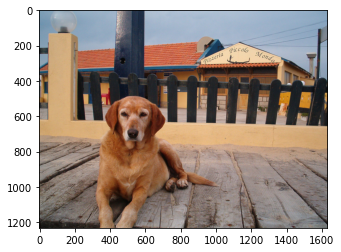

In [10]:
image_file_path = 'sample.jpg'
 

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 

def load_image(image_file_path, transform=None):
    img = Image.open(image_file_path).convert('RGB')
    img = img.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        img = transform(img).unsqueeze(0)
    
    return img
 

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# Build models
encoder_model = CNNModel(256).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1)
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)


# Load the trained model parameters
encoder_model.load_state_dict(torch.load('models_dir/encoder-2-3000.ckpt'))
decoder_model.load_state_dict(torch.load('models_dir/decoder-2-3000.ckpt'))


# Prepare an image
img = load_image(image_file_path, transform)
img_tensor = img.to(device)


# Generate an caption from the image
feat = encoder_model(img_tensor)
sampled_indices = decoder_model.sample(feat)
sampled_indices = sampled_indices[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)


# Convert word_ids to words
predicted_caption = []
for token_index in sampled_indices:
    word = vocabulary.i2w[token_index]
    predicted_caption.append(word)
    if word == '<end>':
        break
predicted_sentence = ' '.join(predicted_caption)


# Print out the image and the generated caption
print (predicted_sentence)
img = Image.open(image_file_path)
plt.imshow(np.asarray(img))

In [11]:
1

1